In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_C.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [6]:
data_std.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_C'] 
X = data_std.drop(['Coeff_C','Name'], axis=1)

### Using CV technique

RF
R2:  0.9093073814263013
RMSE:  0.3011521518662929
---------------------------------------
GB
R2:  0.8595118183215977
RMSE:  0.3748175311780418
---------------------------------------
LR
R2:  -6.495434796411277e+21
RMSE:  80594260319.27632
---------------------------------------
RR
R2:  0.7058109296061279
RMSE:  0.5423919896107169
---------------------------------------
LASSO
R2:  0.9342631793642734
RMSE:  0.25639192778971537
---------------------------------------
gpr1
R2:  0.873115089867607
RMSE:  0.356209082046476
---------------------------------------
gpr2
R2:  0.9248060108977364
RMSE:  0.27421522405268384
---------------------------------------
gpr3
R2:  0.9087292058532292
RMSE:  0.30211056609587605
---------------------------------------
gpr4
R2:  0.9087292062431476
RMSE:  0.3021105654505522
---------------------------------------
gpr5
R2:  0.9239847884318624
RMSE:  0.27570856273996575
---------------------------------------
gpr6
R2:  0.8895290124465202
RMSE:  0.33237176106504

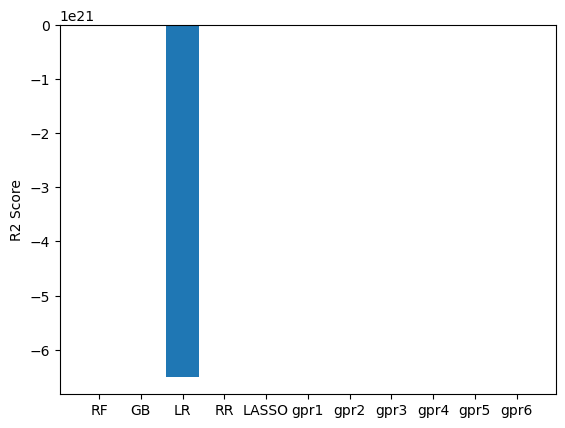

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
11   X_IEII  203.126963
2       X_Z  192.050449
22   X_Rvdw   70.210147
20   A_Rvdw   48.519931
14     X_EA   41.399538
35  X_Kappa   36.035444
6     A_IEI   29.198819
18   A_ChiA   25.074064
8     X_IEI   22.200166
34  B_Kappa   19.185480
31     X_MV   17.753147
13     B_EA   14.125248
0       A_Z   13.564614
15   A_ChiP   12.686824
17   X_ChiP   12.304828
25     A_MP   10.884241
26     B_MP    9.520593
33  A_Kappa    8.983803
1       B_Z    8.916444
36    A_CvM    8.776297
32     B_Hf    8.513339
16   B_ChiP    7.290453
38      A_B    5.706843
28    B_Rho    5.638959
12     A_EA    5.616784
7     B_IEI    5.026239
30     B_MV    4.629268
24     B_Ra    3.358732
3       A_G    3.234213
29    X_Rho    2.459135


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_IEII', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z', 'A_ChiP',
       'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z', 'A_CvM', 'B_Hf',
       'B_ChiP', 'A_B', 'B_Rho', 'A_EA', 'B_IEI', 'B_MV', 'B_Ra', 'A_G',
       'X_Rho', 'B_CvM', 'X_G', 'B_G', 'B_Rvdw', 'A_Rho', 'A_IEII',
       'B_ChiA', 'B_MendeleevNo', 'B_IEII', 'B_B'], dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9038149587492821
RMSE:  0.3101371329762334
---------------------------------------
GB
R2:  0.8599754900738503
RMSE:  0.3741984900105152
---------------------------------------
LR
R2:  -5.966160068431178e+22
RMSE:  244257242849.2383
---------------------------------------
RR
R2:  0.8143399623402998
RMSE:  0.4308828583962237
---------------------------------------
LASSO
R2:  0.9342554517904225
RMSE:  0.2564069971930906
---------------------------------------
gpr1
R2:  0.8915084127327533
RMSE:  0.32938061155333165
---------------------------------------
gpr2
R2:  0.9146257453364874
RMSE:  0.2921887312397804
---------------------------------------
gpr3
R2:  0.9087343069169789
RMSE:  0.3021021235989927
---------------------------------------
gpr4
R2:  0.9087343147289323
RMSE:  0.3021021106696669
---------------------------------------
gpr5
R2:  0.922182454693381
RMSE:  0.27895796333250455
---------------------------------------
gpr6
R2:  0.8911042472251204
RMSE:  0.329993564747677

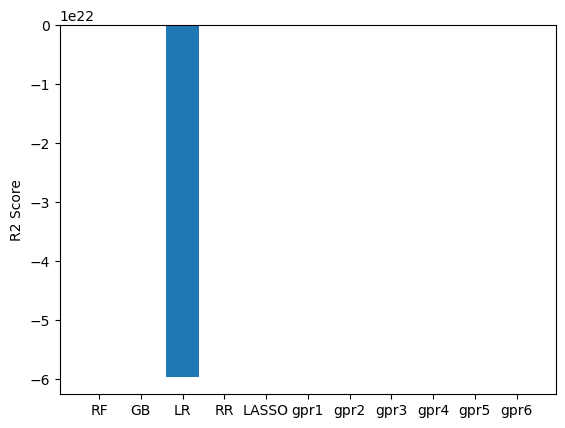

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_IEII', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z', 'A_ChiP',
       'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z', 'A_CvM', 'B_Hf',
       'B_ChiP', 'A_B', 'B_Rho', 'A_EA', 'B_IEI', 'B_MV', 'B_Ra', 'A_G',
       'X_Rho'], dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9103737874401708
RMSE:  0.2993763727481331
---------------------------------------
GB
R2:  0.8414994918016017
RMSE:  0.39812122299420105
---------------------------------------
LR
R2:  -5.811627971652187e+23
RMSE:  762340342081.6838
---------------------------------------
RR
R2:  0.919386299782773
RMSE:  0.28392551878481614
---------------------------------------
LASSO
R2:  0.9302043836039507
RMSE:  0.2641886000493761
---------------------------------------
gpr1
R2:  0.923127857155088
RMSE:  0.2772582601923917
---------------------------------------
gpr2
R2:  0.9308996261241775
RMSE:  0.2628694997062657
---------------------------------------
gpr3
R2:  0.653526629510941
RMSE:  0.5886198862500817
---------------------------------------
gpr4
R2:  0.922425594537361
RMSE:  0.2785218222377541
---------------------------------------
gpr5
R2:  0.9367922326991207
RMSE:  0.25141154965689083
---------------------------------------
gpr6
R2:  0.9070109579723362
RMSE:  0.3049410468068604


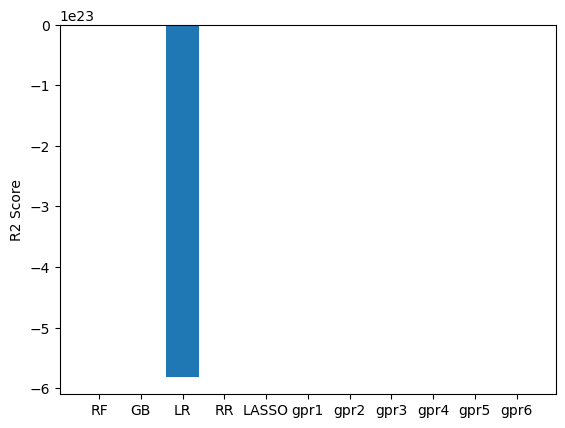

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_IEII', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z', 'A_ChiP',
       'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z', 'A_CvM'], dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9022632877521738
RMSE:  0.31262871308922696
---------------------------------------
GB
R2:  0.8677039241366169
RMSE:  0.3637252752605779
---------------------------------------
LR
R2:  0.9157751890115507
RMSE:  0.2902151115783761
---------------------------------------
RR
R2:  0.9162884748366843
RMSE:  0.28932944054021825
---------------------------------------
LASSO
R2:  0.9229194512219178
RMSE:  0.27763383939657327
---------------------------------------
gpr1
R2:  0.9222789889082667
RMSE:  0.27878488318367145
---------------------------------------
gpr2
R2:  0.9400651182541113
RMSE:  0.24481601611391493
---------------------------------------
gpr3
R2:  0.8219071072995916
RMSE:  0.4220105362433602
---------------------------------------
gpr4
R2:  0.9316847895302997
RMSE:  0.26137178590984206
---------------------------------------
gpr5
R2:  0.9418841750680372
RMSE:  0.24107224006916017
---------------------------------------
gpr6
R2:  0.917970133142663
RMSE:  0.2864085663127

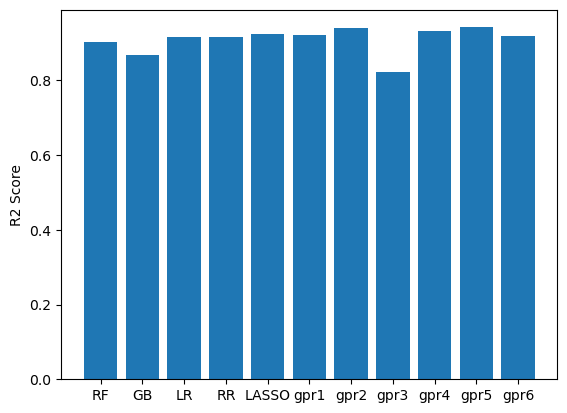

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_IEII', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'A_ChiA', 'X_IEI', 'B_Kappa'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8843211404878589
RMSE:  0.34011595009958157
---------------------------------------
GB
R2:  0.7708965346512604
RMSE:  0.4786475377025768
---------------------------------------
LR
R2:  0.800242827391463
RMSE:  0.4469420237665474
---------------------------------------
RR
R2:  0.8002819372243342
RMSE:  0.4468982689333959
---------------------------------------
LASSO
R2:  0.8044469813414866
RMSE:  0.44221377031760706
---------------------------------------
gpr1
R2:  0.8137792355227598
RMSE:  0.43153303984427455
---------------------------------------
gpr2
R2:  0.8240788972724047
RMSE:  0.41942949673049384
---------------------------------------
gpr3
R2:  0.02409571171465963
RMSE:  0.9878786809549746
---------------------------------------
gpr4
R2:  0.009280233975823449
RMSE:  0.9953490674251805
---------------------------------------
gpr5
R2:  0.7602199710175481
RMSE:  0.48967339011064487
---------------------------------------
gpr6
R2:  0.8484329838903928
RMSE:  0.389316087658

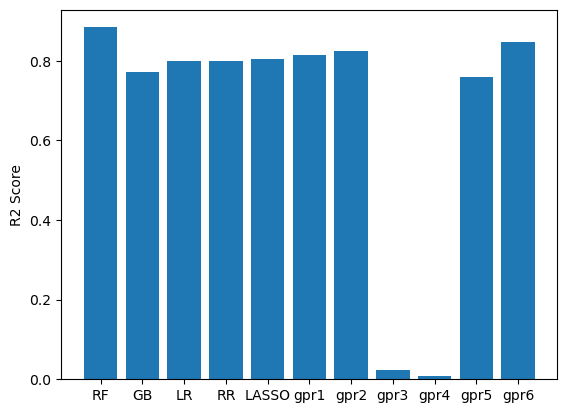

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_C.csv', encoding='cp1252')

In [24]:
data_mm.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_C'] 
X = data_mm.drop(['Coeff_C','Name'], axis=1)

### Using CV technique

RF
R2:  0.9048075501617704
RMSE:  0.07505350260595632
---------------------------------------
GB
R2:  0.9089920912266412
RMSE:  0.07338533487708532
---------------------------------------
LR
R2:  -3.227624647904592e+23
RMSE:  138201012404.2213
---------------------------------------
RR
R2:  0.9551196811622037
RMSE:  0.051534454061450706
---------------------------------------
LASSO
R2:  0.8048310373294782
RMSE:  0.10746699116515038
---------------------------------------
gpr1
R2:  0.8876876198801348
RMSE:  0.08152363357750227
---------------------------------------
gpr2
R2:  0.9349002525635371
RMSE:  0.06206680140057754
---------------------------------------
gpr3
R2:  0.9103385682128466
RMSE:  0.07284043785361977
---------------------------------------
gpr4
R2:  0.9103385689791991
RMSE:  0.07284043754232956
---------------------------------------
gpr5
R2:  0.9336156566449705
RMSE:  0.06267618369415064
---------------------------------------
gpr6
R2:  0.9055228301173928
RMSE:  0.074770

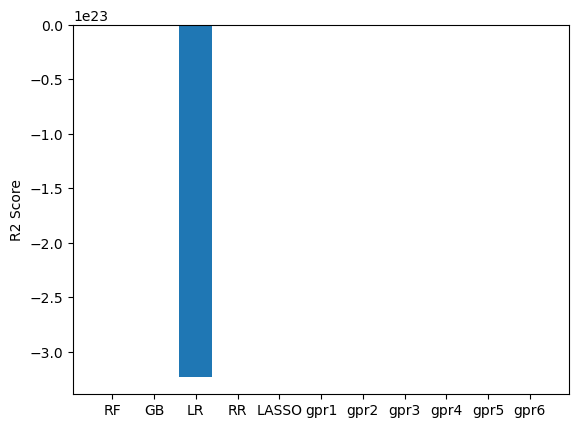

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
2       X_Z  192.050449
11   X_IEII   70.574654
22   X_Rvdw   70.210147
20   A_Rvdw   48.519931
14     X_EA   41.399538
35  X_Kappa   36.035444
6     A_IEI   29.198819
29    X_Rho   26.477661
18   A_ChiA   23.955108
8     X_IEI   22.200166
34  B_Kappa   19.185480
31     X_MV   17.753147
13     B_EA   14.125248
0       A_Z   13.564614
15   A_ChiP   12.686824
17   X_ChiP   12.304828
25     A_MP   10.884241
26     B_MP    9.520593
33  A_Kappa    8.983803
1       B_Z    8.916444
36    A_CvM    8.776297
32     B_Hf    8.513339
16   B_ChiP    7.290453
38      A_B    5.706843
12     A_EA    5.616784
19   B_ChiA    5.284866
7     B_IEI    5.026239
30     B_MV    4.629268
28    B_Rho    4.540251
24     B_Ra    3.358732


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_Z', 'X_IEII', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'X_Rho', 'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z',
       'A_ChiP', 'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z', 'A_CvM',
       'B_Hf', 'B_ChiP', 'A_B', 'A_EA', 'B_ChiA', 'B_IEI', 'B_MV',
       'B_Rho', 'B_Ra', 'A_G', 'B_CvM', 'X_G', 'B_G', 'B_Rvdw', 'A_Rho',
       'A_IEII', 'B_MendeleevNo', 'B_B', 'B_Rc'], dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9053423814528458
RMSE:  0.07484236452240256
---------------------------------------
GB
R2:  0.8959076073541232
RMSE:  0.07848365291370979
---------------------------------------
LR
R2:  -1.2576147104422342e+23
RMSE:  86266765971.68535
---------------------------------------
RR
R2:  0.9441200379209559
RMSE:  0.05750396144131474
---------------------------------------
LASSO
R2:  0.8048293077815627
RMSE:  0.10746746733947708
---------------------------------------
gpr1
R2:  0.927239020925581
RMSE:  0.06561739425071267
---------------------------------------
gpr2
R2:  0.9357237762982823
RMSE:  0.0616729737326793
---------------------------------------
gpr3
R2:  0.9204204218608456
RMSE:  0.06862313097495948
---------------------------------------
gpr4
R2:  0.9204204233217097
RMSE:  0.06862313034509267
---------------------------------------
gpr5
R2:  0.9359146267863877
RMSE:  0.06158134523746691
---------------------------------------
gpr6
R2:  0.9080147720450574
RMSE:  0.07377831

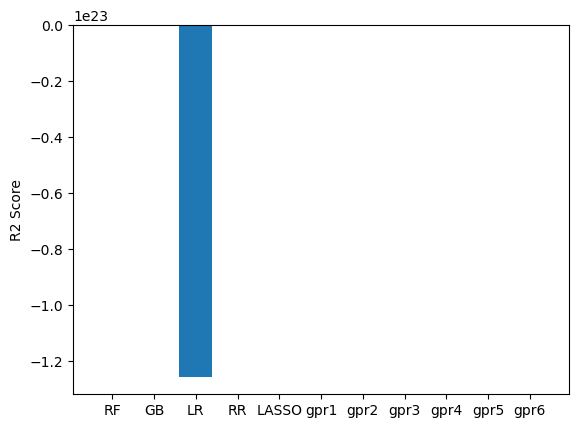

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_Z', 'X_IEII', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'X_Rho', 'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z',
       'A_ChiP', 'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z', 'A_CvM',
       'B_Hf', 'B_ChiP', 'A_B', 'A_EA', 'B_ChiA', 'B_IEI', 'B_MV',
       'B_Rho', 'B_Ra'], dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9076019718560223
RMSE:  0.07394368065174467
---------------------------------------
GB
R2:  0.8930545256373783
RMSE:  0.07955196626023943
---------------------------------------
LR
R2:  -9.631325028738165e+23
RMSE:  238733152222.61832
---------------------------------------
RR
R2:  0.9126487029050057
RMSE:  0.07189594426284972
---------------------------------------
LASSO
R2:  0.8055991669557685
RMSE:  0.10725530289053323
---------------------------------------
gpr1
R2:  0.8832278234270968
RMSE:  0.08312648188842423
---------------------------------------
gpr2
R2:  0.9465802911065089
RMSE:  0.05622383578722075
---------------------------------------
gpr3
R2:  0.25061087670827253
RMSE:  0.21058304709961778
---------------------------------------
gpr4
R2:  0.9373359446531491
RMSE:  0.0608946251488115
---------------------------------------
gpr5
R2:  0.9430460466309374
RMSE:  0.05805393342101944
---------------------------------------
gpr6
R2:  0.9201922336757319
RMSE:  0.068721

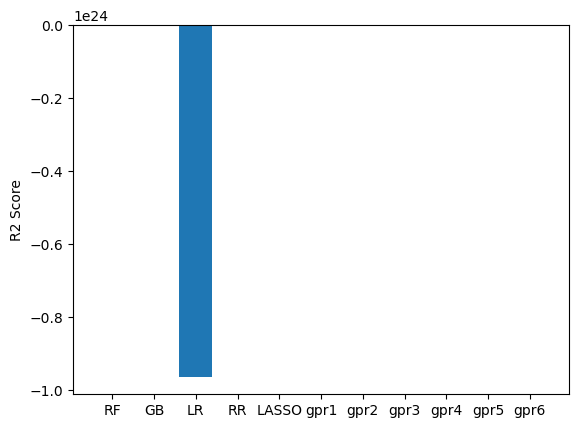

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_Z', 'X_IEII', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'X_Rho', 'A_ChiA', 'X_IEI', 'B_Kappa', 'X_MV', 'B_EA', 'A_Z',
       'A_ChiP', 'X_ChiP', 'A_MP', 'B_MP', 'A_Kappa', 'B_Z'], dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9026431623488868
RMSE:  0.07590195151695939
---------------------------------------
GB
R2:  0.888249722233896
RMSE:  0.08131937245281257
---------------------------------------
LR
R2:  -3.542852287863458e+24
RMSE:  457874266229.9826
---------------------------------------
RR
R2:  0.9255755837919883
RMSE:  0.06636321709613836
---------------------------------------
LASSO
R2:  0.805599188594203
RMSE:  0.10725529692132807
---------------------------------------
gpr1
R2:  0.9241902068009727
RMSE:  0.06697802987243225
---------------------------------------
gpr2
R2:  0.9321815440966361
RMSE:  0.06334956857791184
---------------------------------------
gpr3
R2:  0.22011766705299518
RMSE:  0.21482471976721887
---------------------------------------
gpr4
R2:  0.8969154318822026
RMSE:  0.07810278867658654
---------------------------------------
gpr5
R2:  0.9378394497487899
RMSE:  0.060649487866415774
---------------------------------------
gpr6
R2:  0.927544258673669
RMSE:  0.06547961

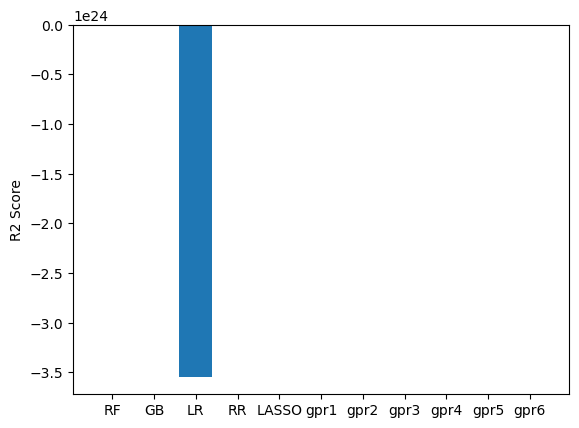

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_Z', 'X_IEII', 'X_Rvdw', 'A_Rvdw', 'X_EA', 'X_Kappa', 'A_IEI',
       'X_Rho', 'A_ChiA', 'X_IEI'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.7215961399407471
RMSE:  0.1283533886922916
---------------------------------------
GB
R2:  0.6630271110078805
RMSE:  0.1412105659149206
---------------------------------------
LR
R2:  0.819367415531656
RMSE:  0.10338743499173318
---------------------------------------
RR
R2:  0.8184594514150664
RMSE:  0.10364695188074081
---------------------------------------
LASSO
R2:  0.7414637633993283
RMSE:  0.12368881369321362
---------------------------------------
gpr1
R2:  0.8192834230948096
RMSE:  0.10341146928598204
---------------------------------------
gpr2
R2:  0.8097160425552766
RMSE:  0.10611353935450123
---------------------------------------
gpr3
R2:  -5.316481266081417
RMSE:  0.6113744977634642
---------------------------------------
gpr4
R2:  -1.1165845923156712
RMSE:  0.35390567604043066
---------------------------------------
gpr5
R2:  -0.4002710588625158
RMSE:  0.28785632016749957
---------------------------------------
gpr6
R2:  -2.2994983038436496
RMSE:  0.4418691358

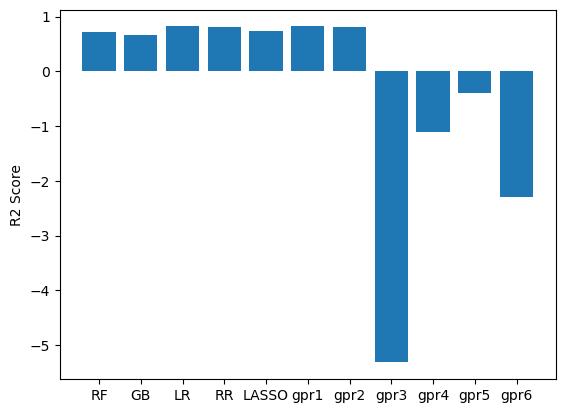

In [40]:
run_models()